<a href="https://colab.research.google.com/github/mcurry572/4540/blob/main/Project3_Michael_Curry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab tutorial for uploading data.

https://colab.research.google.com/notebooks/io.ipynb

In [40]:
import h5py
import numpy as np

filepath = 'Rat08-20130711_017.h5'  # data file
f = h5py.File(filepath, 'r')  # read data with h5 format
fs = f.attrs['fs'][0]  # get sampling frequency of LFP signal (Hz)
print("Sampling rate: %.1f Hz" % (fs))

Sampling rate: 1250.0 Hz


In [41]:
states = []  # two states (NREM & WAKE) to be classified
# LFP recordings are store in two h5 groups for each state
# Under each h5 group, the LFP recordings are divided into several segments with different lengths.
for name, grp in f.items():
  states.append(name)
  print("State: %s" % (name))
  print("Segment IDs:")
  print(list(grp.keys()))

State: NREM
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '7', '8', '9']
State: WAKE
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '4', '5', '6', '7', '8', '9']


In [42]:
# Convert the recording in to numpy arrays
# Use a dictionary to store the LFP recordings of the two states
# each containing a list of numpy arrays of all segments
lfp = {key: [] for key in states}
for key in states:
  group = f[key]  # h5 group of a state
  n = len(group)  # number of segments
  for i in range(n):
    lfp[key].append(group[str(i+1)][()].astype(float))  # convert data to numpy array and from int type to float type

# print(lfp)

Example for accessing a segment.

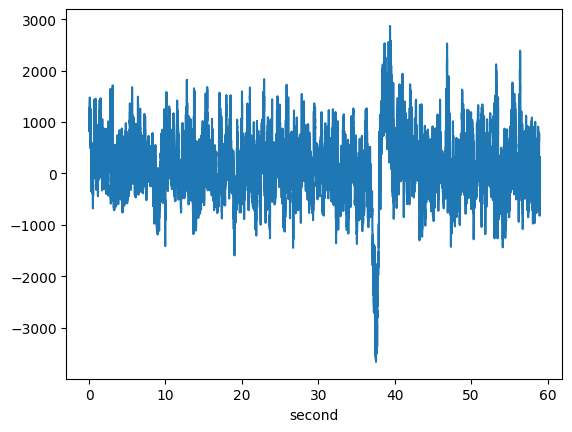

In [43]:
import matplotlib.pyplot as plt

x = lfp['NREM'][10]  # accessing the 10-th LFP segment in NREM state
t = np.arange(x.size)/fs  # time points

plt.plot(t,x)
plt.xlabel('second')
plt.show()

In [44]:
import pandas as pd
import scipy.stats as stats
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset


In [45]:
def extract_features(signal, fs):
    """
    Extract features from a 1D LFP signal segment.
    Returns a vector of statistical and spectral features.
    """
    mean = np.mean(signal)
    std = np.std(signal)
    skew = stats.skew(signal)
    kurt = stats.kurtosis(signal)

    # Power Spectral Density using Welch
    freqs, psd = welch(signal, fs=fs, nperseg=fs)  # 1-second segment

    # Frequency bands (customize as needed)
    delta = np.where((freqs >= 0.5) & (freqs <= 4))[0]
    theta = np.where((freqs >= 4) & (freqs <= 8))[0]
    alpha = np.where((freqs >= 8) & (freqs <= 13))[0]
    beta = np.where((freqs >= 13) & (freqs <= 30))[0]

    delta_power = np.sum(psd[delta])
    theta_power = np.sum(psd[theta])
    alpha_power = np.sum(psd[alpha])
    beta_power = np.sum(psd[beta])
    total_power = np.sum(psd)

    return np.array([mean, std, skew, kurt,
                     delta_power, theta_power, alpha_power, beta_power, total_power])


In [46]:
def create_dataset_from_raw(raw_signal, label, fs, window_sec=5):
    """
    Splits raw signal into fixed-length segments and labels each segment.
    """
    segment_len = fs * window_sec
    features = []
    labels = []

    num_segments = len(raw_signal) // segment_len
    for i in range(num_segments):
        start = i * segment_len
        end = start + segment_len
        clip = raw_signal[start:end]
        if len(clip) == segment_len:
            feat = extract_features(clip, fs)
            features.append(feat)
            labels.append(label)

    return np.array(features), np.array(labels)


In [47]:
def load_h5_and_extract(filename, fs=1000, window_sec=5):
    with h5py.File(filename, 'r') as f:
        states = list(f.keys())  # should be ['NREM', 'WAKE']
        data = {key: [] for key in states}

        for key in states:
            group = f[key]
            for seg_id in group.keys():
                segment = group[seg_id][()].astype(float)
                data[key].append(segment)

        # Flatten and process each segment
        features = []
        labels = []

        for state, label in zip(['NREM', 'WAKE'], [0, 1]):
            for segment in data[state]:
                X_clip, y_clip = create_dataset_from_raw(segment, label, fs=fs, window_sec=window_sec)
                features.append(X_clip)
                labels.append(y_clip)

        X = np.vstack(features)
        y = np.hstack(labels)
        return X, y


In [48]:
# Load and stack datasets
X1, y1 = load_h5_and_extract('Part1SubjectHB10.h5')
X2, y2 = load_h5_and_extract('Part2SubjectHB13.h5')

X = np.vstack([X1, X2])
y = np.hstack([y1, y2])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

print(f"Total Samples: {len(y)}, Features per sample: {X.shape[1]}")
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


Total Samples: 1820, Features per sample: 9
Training samples: 1456, Testing samples: 364


In [49]:
class LFPClassifier(nn.Module):
    def __init__(self, input_dim):
        super(LFPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Binary classification

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

model = LFPClassifier(input_dim=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Epoch 1, Loss: 0.5880
Epoch 2, Loss: 0.4023
Epoch 3, Loss: 0.2894
Epoch 4, Loss: 0.2351
Epoch 5, Loss: 0.2006
Epoch 6, Loss: 0.1778
Epoch 7, Loss: 0.1529
Epoch 8, Loss: 0.1381
Epoch 9, Loss: 0.1235
Epoch 10, Loss: 0.1142
Epoch 11, Loss: 0.1040
Epoch 12, Loss: 0.0983
Epoch 13, Loss: 0.0867
Epoch 14, Loss: 0.0830
Epoch 15, Loss: 0.0838
Epoch 16, Loss: 0.0741
Epoch 17, Loss: 0.0699
Epoch 18, Loss: 0.0660
Epoch 19, Loss: 0.0607
Epoch 20, Loss: 0.0602


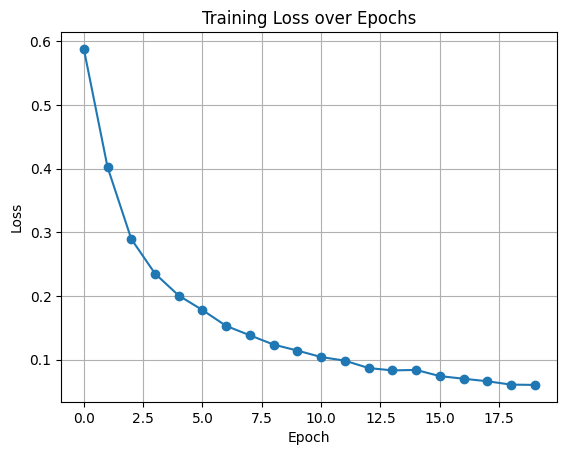

In [50]:
train_losses = []

epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

plt.figure()
plt.plot(train_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


Test Accuracy: 0.9698

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       125
           1       0.99      0.97      0.98       239

    accuracy                           0.97       364
   macro avg       0.96      0.97      0.97       364
weighted avg       0.97      0.97      0.97       364


Class-wise Accuracy:
NREM: 97.60%
WAKE: 96.65%


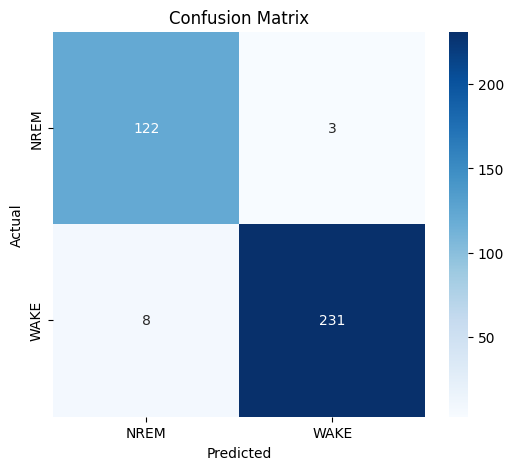

In [51]:
# === Evaluate the Model on Test Data ===
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb)
        _, preds = torch.max(out, 1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        all_preds.extend(preds.tolist())
        all_labels.extend(yb.tolist())

print(f"Test Accuracy: {correct/total:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# === Class Accuracy ===
from sklearn.metrics import accuracy_score
print("\nClass-wise Accuracy:")
for label in [0, 1]:
    idx = [i for i, y_true in enumerate(all_labels) if y_true == label]
    acc = accuracy_score([all_labels[i] for i in idx], [all_preds[i] for i in idx])
    label_name = 'NREM' if label == 0 else 'WAKE'
    print(f"{label_name}: {acc * 100:.2f}%")

# === Visualization of Confusion Matrix ===
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NREM', 'WAKE'], yticklabels=['NREM', 'WAKE'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()




*   LFP signals were segmented into 5 second clips to create data samples
*   These segments were either NREM (labled as 0)or WAKE (labeled as 1)
*   9 features were taken from each sample and with these features we used z score normalization to standarize the given data.
*   as for the architecture, I used a neural network with 2 hidden layers and I used ReLU activation. Cross entropy was used for the loss function as well
*   I have plotted the data I had found above and I was able to learn the difference between brain states.
*   time frequency really helped improving my classification
*   Some of the challenges I had faced were testing with different lengths for the data segments. I found 5 seconds to work well for me. I did run into issues when trying to feature engineer since the signals originally had high dimensions. Using the training data and a little bit of trial adn error I was able to bring the dimensions down.

